## Import Packages

In [33]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim
from sklearn.metrics import roc_auc_score

import pickle



## Import Data

In [2]:
df = pd.read_csv('./water_quality.csv')
display(df.head())

,Well_ID,State,District,Block,Village,Latitude,Longitude,Year,pH,EC,CO3,HCO3,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS,WQI,Water Quality Classification
0,W232200071580001,Gujarat,Ahmedabad,Mandal,Dalod,NaN,NaN,2020,8.20,16640.0,0.0,1257.0,5176.0,822.0,26.00,1451.0,152.0,260.0,3535.0,45.0,1.00,11149,4361.44080,Unsuitable for Drinking
1,W254029084355301,Himachal Pradesh,Solan,Nallagarh,JAGATPUR,31.1594,76.678500,2019,8.44,299.0,43.0,87.0,21.0,0.0,2.70,84.0,17.0,10.0,39.0,2.4,0.20,262,85.80466,Good
2,W193530074180001,Maharashtra,Ahmednagar,SANGAMNER,Kokangaon,74.3000,19.591667,2022,7.90,1315.0,0.0,518.7,120.5,61.6,18.20,465.0,80.2,64.4,88.3,1.6,0.53,372,280.04130,Very Poor yet Drinkable
3,W231620072033001,Gujarat,Ahmedabad,Viramgam,Endla,NaN,NaN,2020,7.40,715.0,0.0,354.0,50.0,18.0,0.23,280.0,56.0,34.0,47.0,11.0,0.46,479,195.11649,Poor
4,W251908084361501,Himachal Pradesh,Solan,Nallagarh,BARUNA,31.1540,76.638400,2019,8.40,270.0,43.0,87.0,14.0,0.0,10.00,116.0,10.0,18.0,23.0,1.0,0.12,262,81.77860,Good


## Exploratory Data Analysis

### Data Shape

In [3]:
print(df.shape)

(19029, 24)


### Display Data Information

In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19029 entries, 0 to 19028
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Well_ID                       15244 non-null  object 
 1   State                         19029 non-null  object 
 2   District                      19029 non-null  object 
 3   Block                         17910 non-null  object 
 4   Village                       19028 non-null  object 
 5   Latitude                      18640 non-null  float64
 6   Longitude                     18639 non-null  float64
 7   Year                          19029 non-null  int64  
 8   pH                            19029 non-null  float64
 9   EC                            19029 non-null  float64
 10  CO3                           19029 non-null  float64
 11  HCO3                          19029 non-null  float64
 12  Cl                            19029 non-null  float64
 13  S

None

### Checking the Categorical Variable

In [5]:
cat_col = list(df.select_dtypes(include=['object']).columns)
for col in cat_col:
    print(f"Number of Unique for {col}: ", len(df[col].unique()))

## We can see a high Categorical Classification in this Columns

Number of Unique for Well_ID:  9806
Number of Unique for State:  14
Number of Unique for District:  600
Number of Unique for Block:  5056
Number of Unique for Village:  11211
Number of Unique for Water Quality Classification:  5


### Checking the Missing Value

In [6]:
print("Percentage of Missing Values: \n", df.isnull().sum()/len(df) * 100)
## No Missing Values for Numerical Columns

Percentage of Missing Values: 
 Well_ID                         19.890693
State                            0.000000
District                         0.000000
Block                            5.880498
Village                          0.005255
Latitude                         2.044248
Longitude                        2.049503
Year                             0.000000
pH                               0.000000
EC                               0.000000
CO3                              0.000000
HCO3                             0.000000
Cl                               0.000000
SO4                              0.000000
NO3                              0.000000
TH                               0.000000
Ca                               0.000000
Mg                               0.000000
Na                               0.000000
K                                0.000000
F                                0.000000
TDS                              0.000000
WQI                              0.000000
Wa

### Checking the Distribution of the Target

#### Values Count

In [7]:
df['Water Quality Classification'].value_counts(normalize=True)

## Notice that there is an imbalance in the dataset

Water Quality Classification
Unsuitable for Drinking    0.347259
Poor                       0.279416
Very Poor yet Drinkable    0.247464
Good                       0.085764
Excellent                  0.040097
Name: proportion, dtype: float64

#### SNS Plot Distribution

<Axes: xlabel='count', ylabel='Water Quality Classification'>

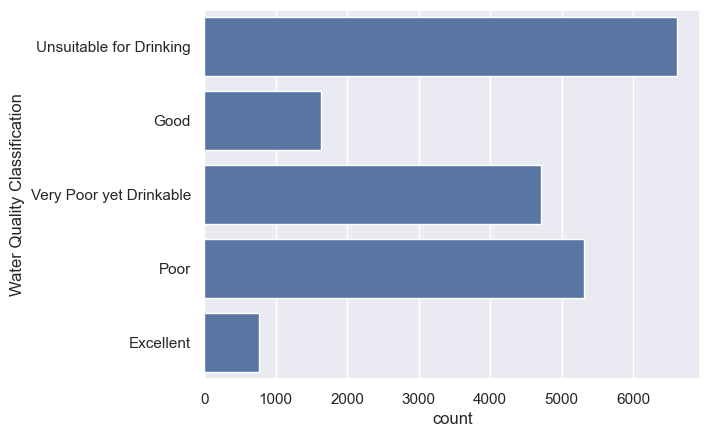

In [8]:
sns.countplot(df['Water Quality Classification'])

### Correlation Heat Map

<Axes: >

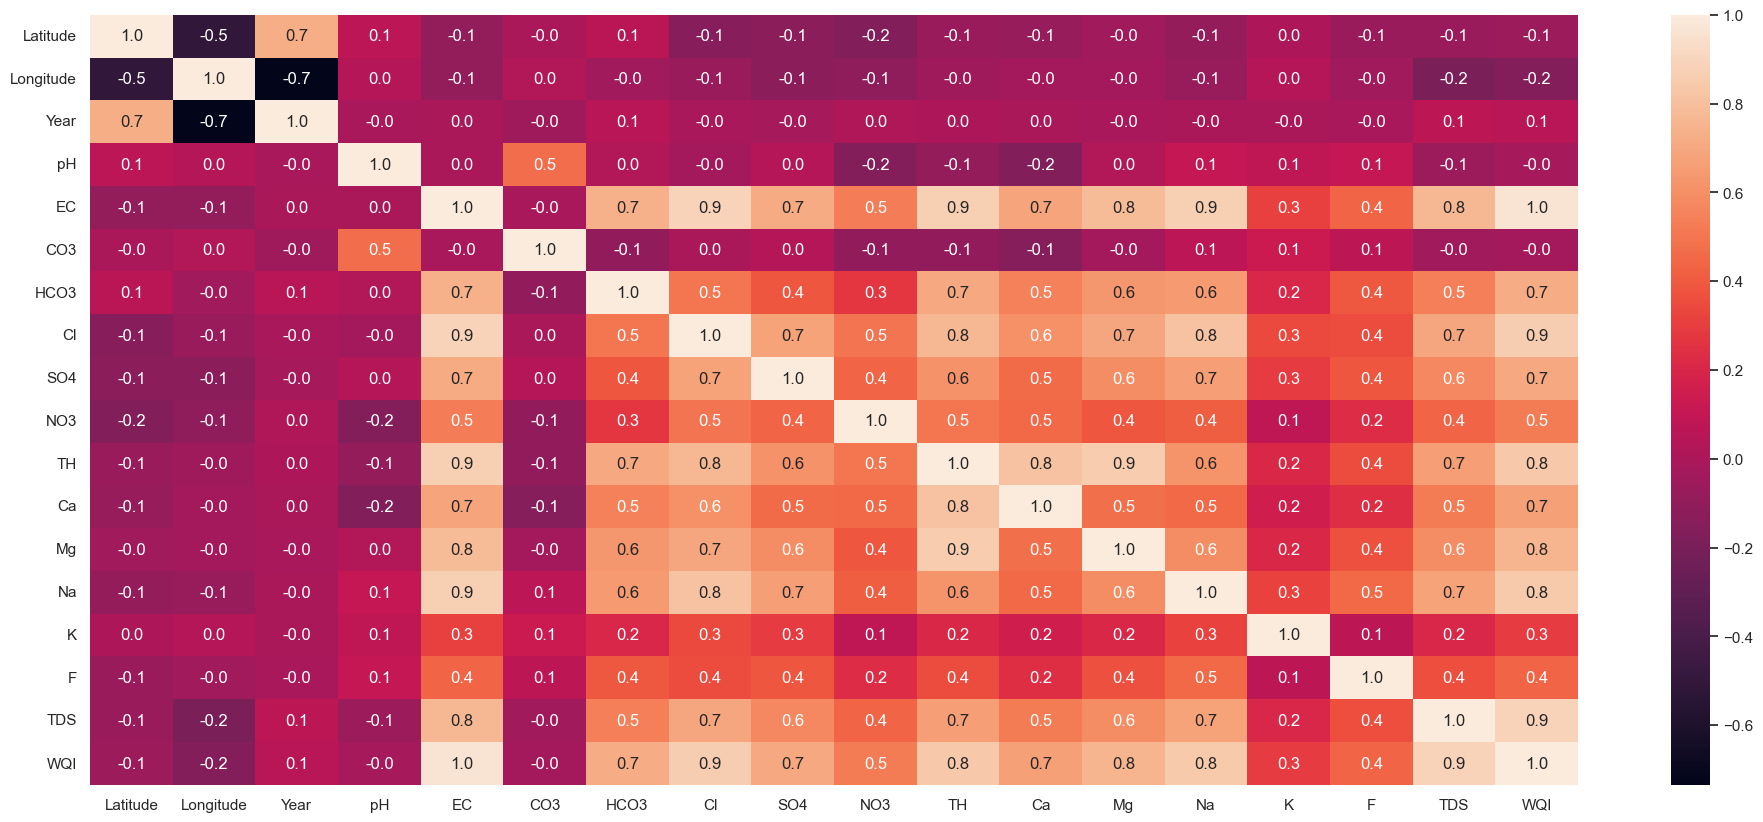

In [9]:
num_col = list(df.select_dtypes(include=['float64', 'int64']).columns)

fig, ax = plt.subplots(figsize=(24,10))         # Sample figsize in inches
sns.heatmap(df[num_col].corr(method='spearman'), annot=True, fmt=".1f")

#### Removing High Colinear Columns

In [10]:
df = df.drop(['Cl', 'TDS'], axis =1)

### Removing Attributes and Missing Values

In [11]:
# Droping High Categorical Columns Such as Distric, Block and Village - Satate, Lat and Long will be used instead to map the location

df = df.drop(['Well_ID', 'District', 'Block', 'Village'] , axis=1)

df = df.loc[(df['Latitude'].notna()) & (df['Longitude'].notna())]

display(df.head())

print("Percentage of Missing Values after Removal: \n", df.isnull().sum()/len(df) * 100)

## Droping was done to avoid Wrong location due to missing lat and long
## Drop as well for Block and Villages

,State,Latitude,Longitude,Year,pH,EC,CO3,HCO3,SO4,NO3,TH,Ca,Mg,Na,K,F,WQI,Water Quality Classification
1,Himachal Pradesh,31.159400,76.678500,2019,8.44,299.0,43.0,87.0,0.0,2.7,84.0,17.0,10.0,39.0,2.4,0.20,85.80466,Good
2,Maharashtra,74.300000,19.591667,2022,7.90,1315.0,0.0,518.7,61.6,18.2,465.0,80.2,64.4,88.3,1.6,0.53,280.04130,Very Poor yet Drinkable
4,Himachal Pradesh,31.154000,76.638400,2019,8.40,270.0,43.0,87.0,0.0,10.0,116.0,10.0,18.0,23.0,1.0,0.12,81.77860,Good
5,Maharashtra,74.900000,19.433333,2022,7.55,1513.0,0.0,292.9,187.4,63.7,510.0,116.2,53.5,96.4,7.2,0.18,376.42330,Unsuitable for Drinking
6,Gujarat,22.376073,71.987684,2020,8.20,7328.0,0.0,1135.0,494.0,220.0,681.0,72.0,122.0,1384.0,44.0,5.00,1944.80480,Unsuitable for Drinking


Percentage of Missing Values after Removal: 
 State                           0.0
Latitude                        0.0
Longitude                       0.0
Year                            0.0
pH                              0.0
EC                              0.0
CO3                             0.0
HCO3                            0.0
SO4                             0.0
NO3                             0.0
TH                              0.0
Ca                              0.0
Mg                              0.0
Na                              0.0
K                               0.0
F                               0.0
WQI                             0.0
Water Quality Classification    0.0
dtype: float64


### Split the Data for Test and Train 

In [12]:
# Split the Data before encodings to avoid data leakage
X = df.drop('Water Quality Classification', axis=1)
y = df[['Water Quality Classification']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

### Map the Target and Perform Dummy Encoder for the State
 

In [13]:
# Define numerical and categorical features
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Create the preprocessing pipelines: scaling for numerical data, and encoding for categorical data
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
    

In [14]:
y['Water Quality Classification'].unique()

array(['Good', 'Very Poor yet Drinkable', 'Unsuitable for Drinking',
       'Poor', 'Excellent'], dtype=object)

In [15]:
maping = { 'Excellent':4,
           'Good': 3,
           'Poor':2,
           'Very Poor yet Drinkable':1,
           'Unsuitable for Drinking':0
}

y_train = y_train['Water Quality Classification'].map(maping)
y_test = y_test['Water Quality Classification'].map(maping)

y_train = pd.DataFrame(y_train, columns=['Water Quality Classification']).reset_index(drop=True)
y_test = pd.DataFrame(y_test, columns=['Water Quality Classification']).reset_index(drop=True)

In [16]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [17]:
# Convert numpy to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.squeeze(), dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.squeeze(), dtype=torch.long)

## Model Using PyTorch

### CREATE THE DATASET CLASS


In [18]:
# This class from your instructor is perfect and doesn't need any changes.
class CustomDataset(Dataset):

    # Its job is to receive your complete dataset (all the features and all the labels) and store them inside the object. 
    # The lines self.features = features and self.labels = labels are essentially saying, "Take these tensors and save them for later use."
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    # A method that returns the length of the dataset.
    def __len__(self):
        return len(self.features)

    # This is the most important method. It means "get item" and its job is to retrieve one single sample from the dataset.
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

###  DEFINE THE NEURAL NETWORK MODEL

In [55]:
# # We'll rename it and adjust the final layer for 5 classes.
# class MultiClassClassifier(nn.Module):
#     def __init__(self, input_features):
#         super(MultiClassClassifier, self).__init__()
#         self.layer1 = nn.Linear(input_features, 256)
#         self.layer2 = nn.Linear(256, 128)
#         self.layer3 = nn.Linear(128, 64)
#         self.layer4 = nn.Linear(64, 5) # <-- CHANGED: Output 5 scores for 5 classes

#     def forward(self, x):
#         x = F.relu(self.layer1(x))
#         x = F.relu(self.layer2(x))
#         x = F.relu(self.layer3(x))
#         x = self.layer4(x) # <-- CHANGED: No sigmoid. Return raw logits.
#         return x

class MultiClassClassifier(nn.Module):
    def __init__(self, input_features):
        super(MultiClassClassifier, self).__init__()
        self.layer1 = nn.Linear(input_features, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 5) # Output layer

        # Define two separate dropout layers with different rates
        # self.dropout1 = nn.Dropout(p=0.25)
        # self.dropout2 = nn.Dropout(p=0.25)

    def forward(self, x):
        # Layer 1 with ReLU activation
        x = F.relu(self.layer1(x))
        # x = self.dropout1(x)

        # Middle layer (layer 2) with tanh activation
        x = F.tanh(self.layer2(x))
        # x = self.dropout2(x)
        
        # Layer 3 with ReLU activation
        x = F.relu(self.layer3(x))
        
        
        # Final linear layer
        x = self.layer4(x) # If return here it only return raw logits
        
        # Softmax activation at the end to convert scores to probabilities
        # dim=1 applies softmax across the class dimension for each sample in the batch
        x = F.softmax(x, dim=1) 
        
        return x


### TRAINING AND EVALUATION FUNCTION

In [56]:
def train_and_evaluate_model(model, optimizer, batch_size=128, epochs=25, print_every=5):
    model.train()  # set model to train mode

    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []

    # Create Dataset and DataLoader objects
    train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = CustomDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    # Use CrossEntropyLoss for multi-class problems
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        # --- Training Phase ---
        model.train()
        for i, (features, labels) in enumerate(train_loader):
            # 1. Clear old gradients
            optimizer.zero_grad()
            # 2. Forward pass: get model's predictions
            outputs = model(features)
            # 3. Calculate the loss (how wrong the predictions are)
            loss = criterion(outputs, labels) # No .squeeze() needed
            # 4. Backward pass: calculate gradients
            loss.backward()
            # 5. Update the model's weights
            optimizer.step()
            train_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(train_accuracy)

        # --- Evaluation Phase ---
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for features, labels in test_loader:
                outputs = model(features)
                loss = criterion(outputs, labels) # No .squeeze() needed
                test_loss += loss.item()

                # Calculate testing accuracy
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        avg_test_loss = test_loss / len(test_loader)
        test_accuracy = 100 * test_correct / test_total
        test_loss_list.append(avg_test_loss)
        test_acc_list.append(test_accuracy)

        if (epoch + 1) % print_every == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

    # --- Plotting ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_loss_list, label='Train Loss')
    plt.plot(range(epochs), test_loss_list, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_acc_list, label='Train Accuracy')
    plt.plot(range(epochs), test_acc_list, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Test Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### RUN THE MODEL

Epoch 10/70, Train Loss: 1.0493, Test Loss: 1.0556, Train Acc: 85.75%, Test Acc: 85.19%
Epoch 20/70, Train Loss: 1.0446, Test Loss: 1.0535, Train Acc: 86.13%, Test Acc: 85.11%
Epoch 30/70, Train Loss: 1.0421, Test Loss: 1.0606, Train Acc: 86.41%, Test Acc: 84.68%
Epoch 40/70, Train Loss: 1.0411, Test Loss: 1.0526, Train Acc: 86.43%, Test Acc: 85.35%
Epoch 50/70, Train Loss: 1.0425, Test Loss: 1.0511, Train Acc: 86.22%, Test Acc: 85.52%
Epoch 60/70, Train Loss: 1.0387, Test Loss: 1.0474, Train Acc: 86.68%, Test Acc: 85.89%
Epoch 70/70, Train Loss: 1.0375, Test Loss: 1.0477, Train Acc: 86.79%, Test Acc: 85.92%


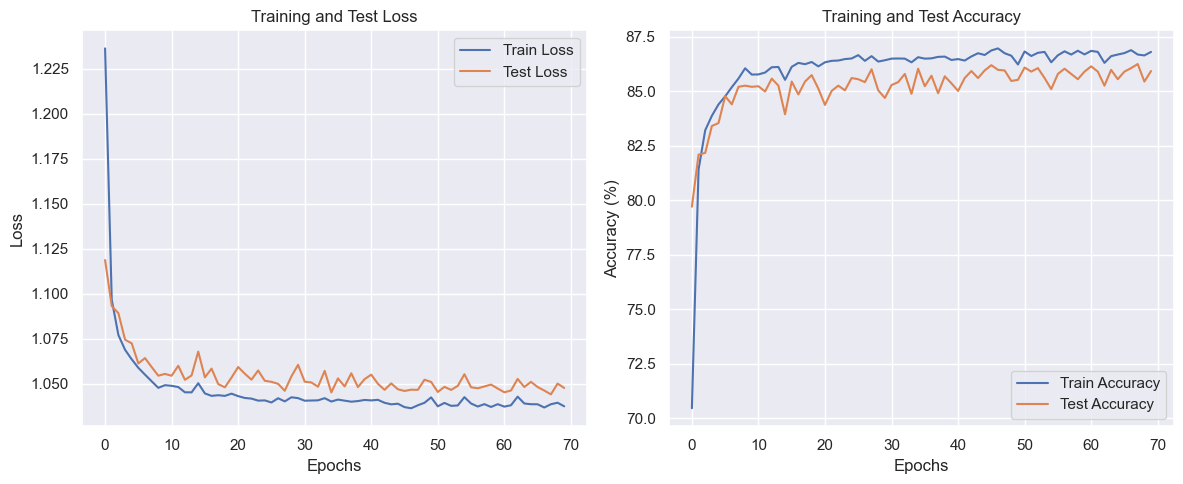

In [61]:
# Instantiate the model
model = MultiClassClassifier(input_features=X_train.shape[1])
# Initialize Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# Train and evaluate
train_and_evaluate_model(model, optimizer, epochs=70, print_every=10)

### SAVE MODEL

In [58]:
# Save the model's state dictionary
MODEL_PATH = "./water_quality_classifier.pth"
WEIGHT_PATH = "./preprocessor.pkl"

torch.save(model.state_dict(), MODEL_PATH)

# 2. Save the preprocessor object
with open(WEIGHT_PATH, "wb") as f:
    pickle.dump(preprocessor, f)

print(f"Model and Weight saved successfully at {MODEL_PATH}")



Model and Weight saved successfully at ./water_quality_classifier.pth


### LOAD MODEL

#### LOAD THE SAVED OBJECTS

In [59]:
# Load the preprocessor
with open("preprocessor.pkl", "rb") as f:
    loaded_preprocessor = pickle.load(f)

# The model was trained on the OUTPUT of the preprocessor, which has 30 features.
# So, we initialize the model architecture to accept 30 input features.
input_features_for_model = 30
loaded_model = MultiClassClassifier(input_features=input_features_for_model)

# Load the saved weights into the model instance
loaded_model.load_state_dict(torch.load("water_quality_classifier.pth"))
loaded_model.eval()

print("Preprocessor and Model loaded successfully.")

Preprocessor and Model loaded successfully.


#### PREDICT ON NEW RAW DATA

In [60]:
new_data = {
    'State': ['Himachal Pradesh'],
    'Latitude': [31.1594],
    'Longitude': [76.6785],
    'Year': [2019],
    'pH': [8.44],
    'EC': [299.0],
    'CO3': [43.0],
    'HCO3': [87.0],
    'SO4': [0.0],
    'NO3': [2.78],
    'TH': [84.0],
    'Ca': [17.0],
    'Mg': [10.0],
    'Na': [39.0],
    'K': [2.4],
    'F': [0.20],
    'WQI': [85.80466]
    # This dictionary defines 17 features.
}
new_df = pd.DataFrame(new_data)

# Use the loaded preprocessor to transform the 17-feature DataFrame.
# This will output a NumPy array with 30 features.
new_data_processed = loaded_preprocessor.transform(new_df)
if hasattr(new_data_processed, "toarray"):
    new_data_processed = new_data_processed.toarray()

# Convert to a tensor
new_sample_tensor = torch.tensor(new_data_processed, dtype=torch.float32)

# Make the prediction with the loaded model
with torch.no_grad():
    output = loaded_model(new_sample_tensor)

_, predicted_index = torch.max(output, 1)

# Map index to class name
class_mapping = { 0: 'Unfit for Drinking', 1: 'Very Poor yet Drinkable', 2: 'Poor', 3: 'Good', 4: 'Excellent' }
predicted_class_name = class_mapping[predicted_index.item()]

print(f"\nPrediction: {predicted_class_name}")


Prediction: Poor
